In [28]:
#Setup modules
import pandas as pd
import numpy as np
#pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, plot_importance
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.stats import norm
print("Setup Complete")

Setup Complete


In [29]:
train = pd.read_csv(r"C:\Users\paraicoreilly\Desktop\project_code\PM\all_data_organised.csv",index_col="date",parse_dates=True,dayfirst=True)
test = pd.read_csv(r'C:\Users\paraicoreilly\Desktop\project_code\PM\PM25_test.csv')
print("data loaded \n")
#Check the first few rows and describte the data to check it is loaded in correctly

#Drop the rows that have missing values from the data frame - need to adjust this - try with mean values filling in - also need to set aside data for test set
train.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)

data loaded 



In [30]:
#Check the first few rows and describte the data to check it is loaded in correctly
print(train.head(3))
print("\n")
print(train.describe())
print("\n")

            PM25  temp  r_hum  wdsp   msl
date                                     
2009-01-01  31.1   3.4   90.4   7.8  1029
2009-01-02  15.2   3.7   77.4   8.5  1031
2009-01-03  17.4   2.8   67.0   6.1  1030


              PM25         temp        r_hum         wdsp          msl
count  3302.000000  3302.000000  3302.000000  3302.000000  3302.000000
mean     10.280389     9.433404    83.037068    10.696972  1013.277408
std       8.899069     4.628948     7.247680     4.308760    12.031891
min      -0.200000    -8.100000    54.000000     2.300000   960.000000
25%       5.000000     6.100000    78.100000     7.500000  1006.000000
50%       7.300000     9.500000    83.200000     9.900000  1014.000000
75%      12.200000    13.200000    88.300000    13.300000  1021.000000
max     107.700000    21.100000   100.000000    28.800000  1042.000000




In [32]:
#Check the first few rows and describte the data to check it is loaded in correctly
print(train.head(3))
print("\n")
print(train.describe())
print("\n")

            PM25  temp  r_hum  wdsp   msl
date                                     
2009-01-01  31.1   3.4   90.4   7.8  1029
2009-01-02  15.2   3.7   77.4   8.5  1031
2009-01-03  17.4   2.8   67.0   6.1  1030


              PM25         temp        r_hum         wdsp          msl
count  3302.000000  3302.000000  3302.000000  3302.000000  3302.000000
mean     10.280389     9.433404    83.037068    10.696972  1013.277408
std       8.899069     4.628948     7.247680     4.308760    12.031891
min      -0.200000    -8.100000    54.000000     2.300000   960.000000
25%       5.000000     6.100000    78.100000     7.500000  1006.000000
50%       7.300000     9.500000    83.200000     9.900000  1014.000000
75%      12.200000    13.200000    88.300000    13.300000  1021.000000
max     107.700000    21.100000   100.000000    28.800000  1042.000000




In [33]:
# Outlier detection
up_p = train['PM25'].mean() + 2*train['PM25'].std()
low_p = train['PM25'].mean() - 2*train['PM25'].std()
# Replace outlier by interpolation for base consumption
train.loc[train['PM25'] > up_p, 'PM25'] = np.nan
train.loc[train['PM25'] < low_p, 'PM25'] = np.nan
train['PM25'].interpolate(inplace=True)
train.dropna(axis=0, inplace=True)

print(train.describe())

              PM25         temp        r_hum         wdsp          msl
count  3301.000000  3301.000000  3301.000000  3301.000000  3301.000000
mean      9.154197     9.435232    83.034838    10.697849  1013.272645
std       5.699262     4.628457     7.247644     4.309118    12.030600
min      -0.200000    -8.100000    54.000000     2.300000   960.000000
25%       5.000000     6.100000    78.100000     7.500000  1006.000000
50%       7.300000     9.500000    83.200000     9.900000  1014.000000
75%      11.900000    13.200000    88.300000    13.300000  1021.000000
max      28.000000    21.100000   100.000000    28.800000  1042.000000


In [34]:
#Store PM_25 (the target variable) in y 
y = train.PM25
y.describe()
#Store the names of features that are to be used as predictors
features = ['wdsp','temp','r_hum','msl']
#Store the data for the features in X
X = train[features] 
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1, test_size = .2)

In [35]:
def normalize_feature(feature):
    # Shift the feature so that all values are positive
    feature_shifted = feature - np.min(feature) + 1e-6
    # Apply Box-Cox transformation
    feature_normalized, _ = stats.boxcox(feature_shifted)
    return feature_normalized


In [37]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1,test_size = .2)

In [38]:
def inverse_transform_feature(feature_normalized):
    # Inverse Box-Cox transformation
    feature_shifted = stats.boxcox(feature_normalized, lmbda=None)
    # Shift back to original range
    feature = feature_shifted + np.min(feature_normalized) - 1e-6
    return feature


In [39]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))
# Fit the scaler using available training data
input_scaler = scaler_x.fit(train_X)
train_x_norm = input_scaler.transform(train_X)
test_x_norm = input_scaler.transform(val_X)



In [41]:
XGBModel = XGBRegressor(colsample_bytree= 0.7,n_estimators=1000, learning_rate=0.01, max_depth = 3, min_child_weight =1,)
XGBModel.fit(train_x_norm,train_y , verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [42]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(XGBModel, train_x_norm, train_y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 3.125 (0.181)


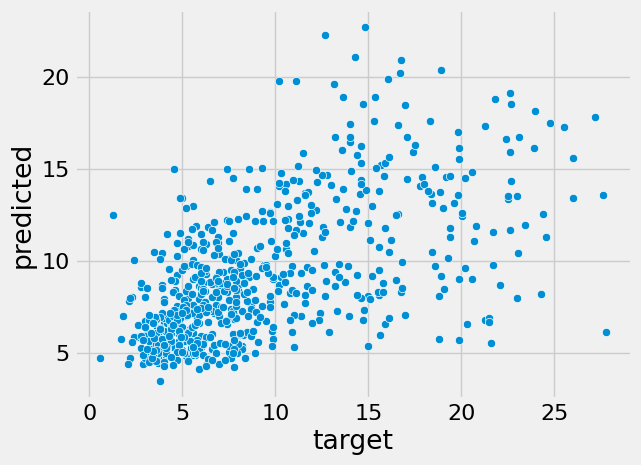

Metrics for the validation set:

Mean Absolute Error: 3.2846554265838135
Mean Squared Error: 20.002925988656326
root mean squared erro 4.472463078512368
R^2 Score: 0.36310795221402514
The score is 0.41093


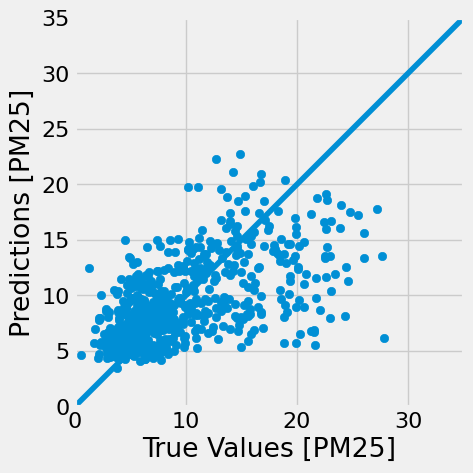

In [50]:
val_pred = XGBModel.predict(test_x_norm)

val_data = pd.DataFrame({'target': val_y, 'predicted': val_pred.flatten()})
# Plot the scatterplot using the combined DataFrame
sns.scatterplot(data=val_data, x='target', y='predicted')
plt.show()
# calculate metrics
mae = mean_absolute_error(val_y, val_pred)
mse = mean_squared_error(val_y, val_pred)
r2 = r2_score(val_y, val_pred)

print('Metrics for the validation set:\n')
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('root mean squared erro', np.sqrt(mse))
print('R^2 Score:', abs(r2))


RMSLE = np.sqrt( mean_squared_log_error(val_y, val_pred) )
print("The score is %.5f" % RMSLE )



a = plt.axes(aspect='equal')
plt.scatter(val_y, val_pred.flatten())
plt.xlabel('True Values [PM25]')
plt.ylabel('Predictions [PM25]')
lims = [0, 35]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)



In [44]:
# param_grid = {"max_depth":    [3, 10],
#               "n_estimators": [100, 500, 1000],
#                "learning_rate": [0.01, 0.05,.01],
#                'max_depth':range(3,10,2),
#                'min_child_weight':range(1,6,3),
#                'colsample_bytree': [0.3, 0.7]}
               

# #try out every combination of the above values
# search = GridSearchCV(XGBModel, param_grid, cv=5).fit(train_X, train_y)

# print("The best hyperparameters are ",search.best_params_)

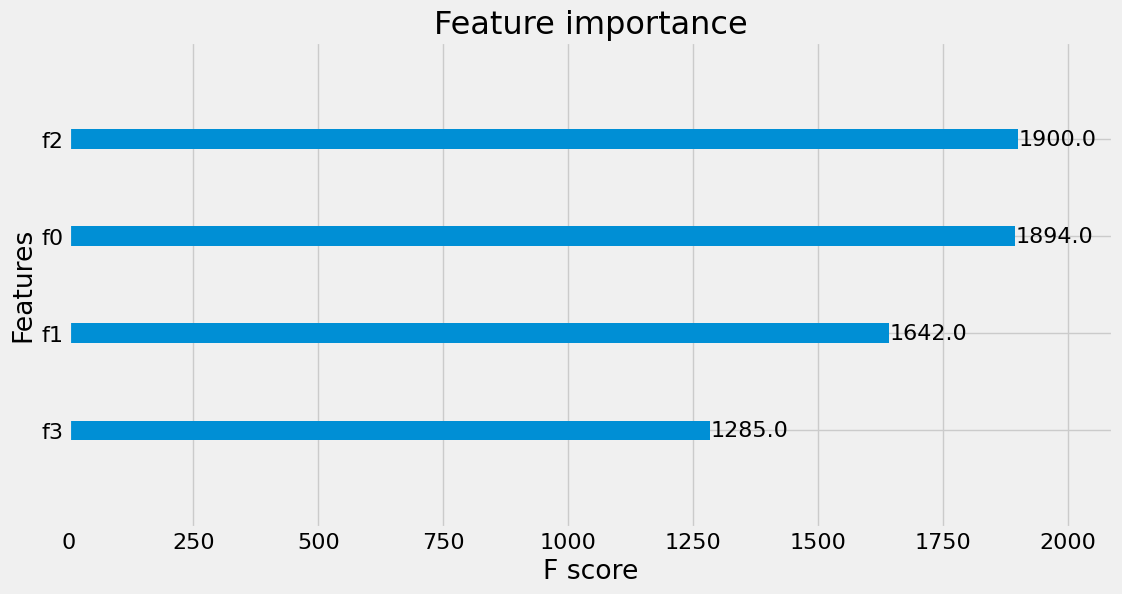

In [45]:

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(XGBModel, max_num_features=8, ax=ax)
plt.show();

In [46]:
up_p = test['PM25'].mean() + 2*test['PM25'].std()
low_p = test['PM25'].mean() - 2*test['PM25'].std()
# Replace outlier by interpolation for base consumption
test.loc[test['PM25'] > up_p, 'PM25'] = np.nan
test.loc[test['PM25'] < low_p, 'PM25'] = np.nan
test['PM25'].interpolate(inplace=True)
test.dropna(axis=0, inplace=True)


Metrics for the test set:

Mean Absolute Error: 3.5573173116396553
Mean Squared Error: 18.415802425202415
R^2 Score: 0.09953469829057604


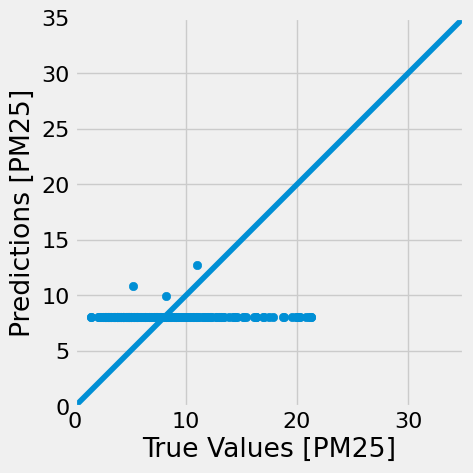

In [49]:
#Load in the test data
test_y = test.PM25
test_x = test[features]



test_pred = XGBModel.predict(test_x)

# calculate metrics
mae = mean_absolute_error(test_y, test_pred)
mse = mean_squared_error(test_y, test_pred)
r2 = r2_score(test_y, test_pred)

print('Metrics for the test set:\n')
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R^2 Score:', abs(r2))





a = plt.axes(aspect='equal')
plt.scatter(test_y, test_pred)
plt.xlabel('True Values [PM25]')
plt.ylabel('Predictions [PM25]')
lims = [0, 35]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)



Metrics for the test set:

Mean Absolute Error: 4.293712258924048
Mean Squared Error: 31.619348442542762
R^2 Score: 0.03350573539685997


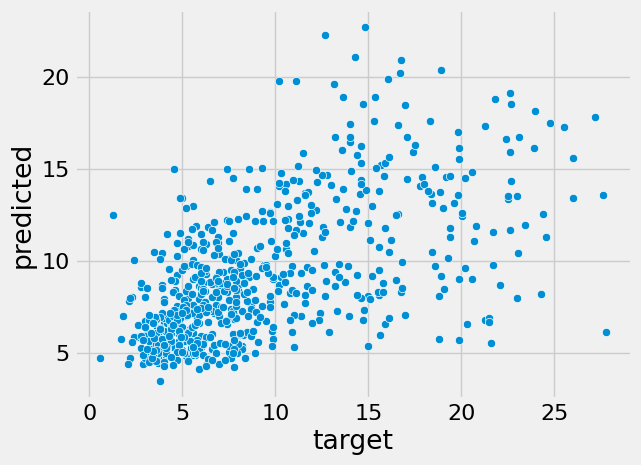

In [48]:
cork = pd.read_csv(r'C:\Users\paraicoreilly\Desktop\project_code\PM\All_Cork_Data.csv')


up_p = cork['PM25'].mean() + 2*cork['PM25'].std()
low_p = cork['PM25'].mean() - 2*cork['PM25'].std()
# Replace outlier by interpolation for base consumption
cork.loc[cork['PM25'] > up_p, 'PM25'] = np.nan
cork.loc[cork['PM25'] < low_p, 'PM25'] = np.nan
cork['PM25'].interpolate(inplace=True)


cork.dropna(axis=0,inplace=True)

#Load in the test data
testcork_y = cork.PM25
cork_features = ['wdsp','r_hum','temp','msl']
testcork_x = cork[cork_features]





testcork_pred = XGBModel.predict(testcork_x)

# calculate metrics
mae = mean_absolute_error(testcork_y, testcork_pred)
mse = mean_squared_error(testcork_y, testcork_pred)
r2 = r2_score(testcork_y, testcork_pred)

print('Metrics for the test set:\n')
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R^2 Score:', abs(r2))



test_data = pd.DataFrame({'target': testcork_y, 'predicted': testcork_pred.flatten()})
# Plot the scatterplot using the combined DataFrame
sns.scatterplot(data=val_data, x='target', y='predicted')
plt.show()